In [24]:
import cv2
import matplotlib.pyplot as plt

In [25]:
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print((major_ver, minor_ver, subminor_ver) )

('4', '1', '1')


In [26]:
vidcap = cv2.VideoCapture('bohemian_rhapsody_live_aid.mp4')

In [27]:
total_frames = vidcap.get(7)

In [28]:
total_frames

10885.0

In [29]:
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)

59.94005994005994


In [30]:
total_frames/60

181.41666666666666

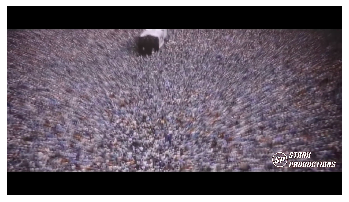

In [31]:
cap.set(1, 600)
ret, frame = cap.read()
plt.axis('off')
plt.imshow(frame)
plt.show()

In [32]:
frames_to_analyze = []
w = 60
jump = 120
for i in range(w + 1, int(total_frames), 2*w):
    cap.set(1, i)
    _, frame = cap.read()
    
    cap.set(1, i - 2*w)
    ret, past_frame = cap.read()
    
    frames_to_analyze.append([past_frame, frame])

In [48]:
def show_frames(index, figsize=20):
    fig = plt.figure(figsize=(figsize, figsize))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(frames_to_analyze[index][0])
    ax1.axis('off')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(frames_to_analyze[index][1])
    ax2.axis('off')

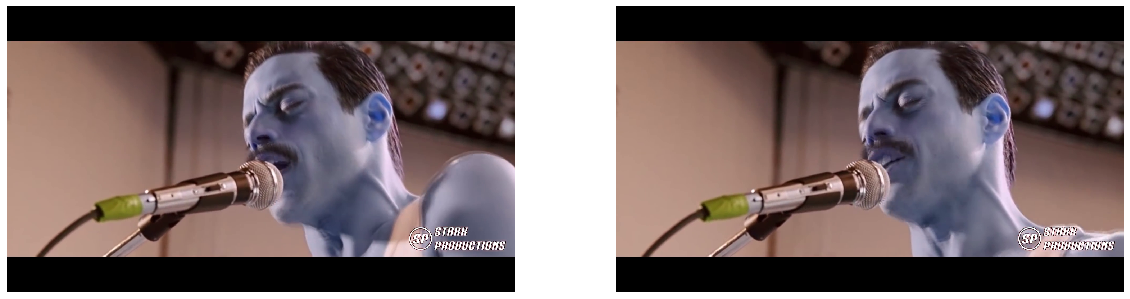

In [65]:
show_frames(49)
# show_frames(50)